##I/We certify that the code and data in this assignment were generated independently, using only the tools and resources defined in the course and that I did not receive any external help, coaching or contributions during the production of this work.


In [ ]:
%pip install -U tf-agents pyvirtualdisplay
%pip install -U gym>=0.21.0
%pip install -U gym[box2d,atari,accept-rom-license]

     |████████████████████████████████| 1.3 MB 30.4 MB/s 
     |████████████████████████████████| 18.3 MB 58 kB/s 
     |████████████████████████████████| 2.1 MB 28.7 MB/s 
     |████████████████████████████████| 1.6 MB 60.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441027 sha256=439da6b7a319eca2a4c3c241109f9c8895030f35d5df60141ab6b3c3f5a2ccaf
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c403a9538a
Successfully built AutoROM.accept-rom-license


In [ ]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import gym

import math
import random

import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
#from google.colab import output
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


In [ ]:
env=gym.make("ALE/Boxing-v5")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

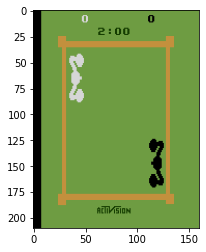

In [ ]:
plt.imshow(env.render(mode="rgb_array"))
plt.show()

In [ ]:
print("Observation Space : " , env.observation_space)
print("Action Space : " ,env.action_space)

Observation Space :  Box(0, 255, (210, 160, 3), uint8)
Action Space :  Discrete(18)


In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()

        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32

        self.model_conv = nn.Sequential(nn.Conv2d(3, 3, kernel_size=5, stride=2),
                              nn.BatchNorm2d(3),
                              nn.ReLU(),
                              nn.Conv2d(3, 18, kernel_size=5, stride=2),
                              nn.BatchNorm2d(18),
                              nn.ReLU(),
                              nn.Conv2d(18, 32, kernel_size=5, stride=2),
                              nn.BatchNorm2d(32),
                              nn.ReLU(),
                              )
        self.model_linear = nn.Sequential(nn.Linear(linear_input_size, 32),
                                     nn.ReLU(),
                                     nn.Linear(32, 32),
                                     nn.ReLU(),
                                     nn.Linear(32, outputs)
                                     )


    def forward(self, x):
        x = x.to(device)
        x = self.model_conv(x)
        x = self.model_linear(x.view(x.size(0), -1))
        return x

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


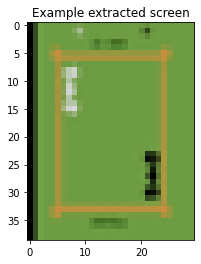

In [ ]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(30, interpolation=Image.CUBIC),
                    T.ToTensor()])


def reduce_dim(obs):
    obs = obs.transpose((2, 0, 1))
    obs = torch.from_numpy(obs)
    return resize(obs).unsqueeze(0)

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    next_state_batch = torch.cat(batch.next_state) 

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = target_net(next_state_batch).max(1)[0].detach()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch


    criterion = nn.MSELoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [ ]:
BATCH_SIZE = 128
GAMMA = 0.99
TARGET_UPDATE = 10
Learning_rate=0.005


obs = reduce_dim(env.reset())
_, _,height, width = obs.shape
n_actions = env.action_space.n

policy_net = DQN(height, width, n_actions).to(device)
target_net = DQN(height, width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters(),lr=Learning_rate)
memory = ReplayMemory(100000000)


steps_done = 0


def select_action(state,episod,max_episod):
    ep = np.exp(-8*episod/max_episod)
    action_prob= ep*np.ones((env.action_space.n,))/env.action_space.n
    greedy_action=policy_net(state).max(1)[1].view(1, 1)
    greedy_action=greedy_action.item()
    action_prob[greedy_action] += 1 - ep
    action_prob = action_prob/np.sum(action_prob)
    action = np.random.choice(range(env.action_space.n),p=action_prob)
    return   torch.Tensor([[action]]).type(torch.int64).to(device) , ep


In [ ]:
num_episodes = 100
rewardPerEpisode=[]
action_taken=[]
time_taken=[]
eps = []
for i_episode in range(num_episodes):
    obs = env.reset()
    state = reduce_dim(obs)
    acc_reward= 0 
    for t in count():

        action , ep  = select_action(state,i_episode,num_episodes)
        action_taken.append(action.item())
        obs, reward, done, _ = env.step(action.item())

        acc_reward += reward
        next_state = reduce_dim(obs)

        reward = torch.tensor([reward], device=device)
        memory.push(state, action, next_state, reward)

        state = next_state
        optimize_model()
        if done :
          rewardPerEpisode.append(acc_reward)
          time_taken.append(t)
          eps.append(ep)
          break
    
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    print(i_episode,rewardPerEpisode[i_episode], time_taken[i_episode], eps[i_episode])

print('Complete')

0 2.0 1786 1.0
1 -1.0 1786 0.9231163463866358
2 -3.0 1786 0.8521437889662113
3 0.0 1786 0.7866278610665535
4 5.0 1786 0.7261490370736909
5 5.0 1786 0.6703200460356393
6 -8.0 1786 0.6187833918061408
7 1.0 1786 0.5712090638488149
8 3.0 1786 0.5272924240430485
9 -1.0 1786 0.4867522559599717
10 -7.0 1786 0.44932896411722156
11 -12.0 1786 0.4147829116815814
12 -2.0 1786 0.38289288597511206
13 -5.0 1786 0.35345468195878016
14 -34.0 1786 0.32627979462303947
15 -8.0 1786 0.30119421191220214
16 -1.0 1786 0.27803730045319414
17 -19.0 1786 0.2566607769535559
18 -3.0 1786 0.23692775868212176
19 -14.0 1786 0.21871188695221475
20 -6.0 1786 0.20189651799465538
21 4.0 1786 0.18637397603940997
22 -7.0 1786 0.17204486382305054
23 -17.0 1786 0.15881742610692068
24 -28.0 1786 0.14660696213035015
25 -24.0 1786 0.1353352832366127
26 -23.0 1786 0.12493021219858241
27 -20.0 1786 0.11532512103806251
28 -7.0 1786 0.1064585043792528
29 -17.0 1786 0.09827358560436154
30 -13.0 1786 0.09071795328941251
31 -15.0 178

[-100.0, -100.0]


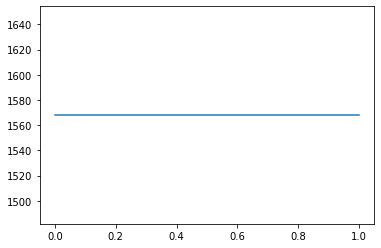

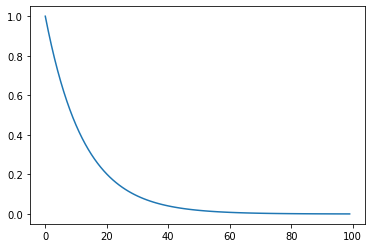

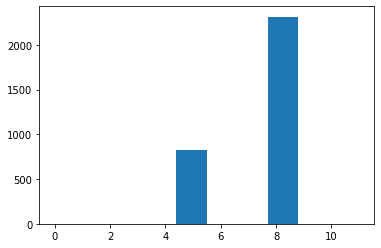

In [ ]:
plt.plot(rewardPerEpisode)
plt.figure()
plt.plot(time_taken)
plt.figure()
plt.plot(eps)
plt.figure()
plt.hist(action_taken)
plt.show()

In [ ]:
num_episodes = 10
rewardPerEpisode=[]
action_taken=[]
time_taken=[]
for i_episode in range(num_episodes):
    obs = env.reset()
    state = reduce_dim(obs)
    acc_reward= 0 
    for t in count():

        action, ep= select_action(state,num_episodes,num_episodes)
        action_taken.append(action.item())
        obs, reward, done, _ = env.step(action.item())
        acc_reward += reward
        reward = torch.tensor([reward], device=device)
        next_state = reduce_dim(obs)
        state = next_state
        if done :
          rewardPerEpisode.append(acc_reward)
          time_taken.append(t)
          print(i_episode,rewardPerEpisode[i_episode], time_taken[i_episode])
          break

print('Complete')

0 -100.0 1721
1 -100.0 1568
2 -89.0 1786
3 -100.0 1721
4 -98.0 1745
5 -100.0 1721
6 -100.0 1568
7 -98.0 1786
8 -100.0 1568
9 -92.0 1786
Complete


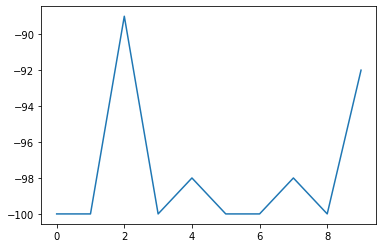

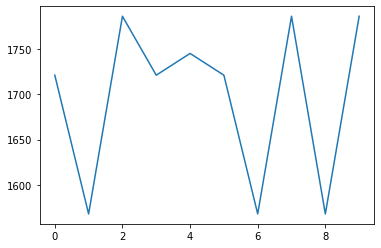

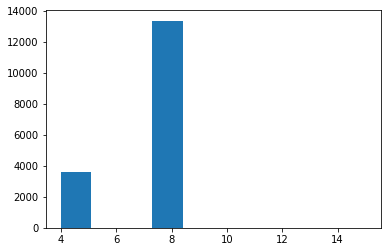

In [ ]:
plt.plot(rewardPerEpisode)
plt.figure()
plt.plot(time_taken)
plt.figure()
plt.hist(action_taken)
plt.show()